# Etude de marché

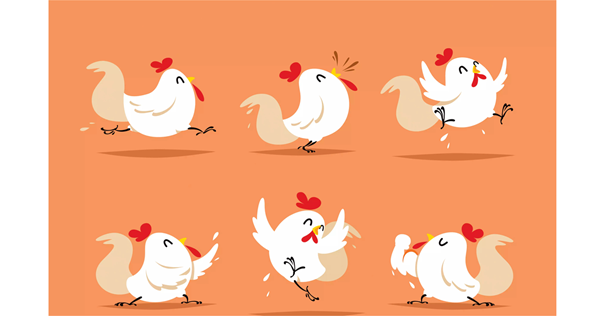

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
import sklearn as sk
import scipy as sp
import scipy.stats as stats
from sklearn import decomposition, preprocessing
from scipy.stats import fligner
from scipy.stats import shapiro
from scipy.stats import wilcoxon
import pca as pca

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import matplotlib.patches as mpatches

from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing

import scipy as st
import scipy.stats as stats
from scipy.stats import fligner
from scipy.stats import shapiro

In [3]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [4]:
poulet = pd.read_csv('poulet-p5.csv')
bilan_alim = pd.read_csv('bilan-alim-p5.csv')
population = pd.read_csv('population-p5.csv')
sécurité = pd.read_csv('sécurité-stabilité-p5.csv')

In [5]:
sns.set(
    style='whitegrid',
    context='notebook',
    palette='Paired',
    rc={'figure.figsize':(8,5)})

In [6]:
red_a400 = '#ff1744'
indigo_a100 = '#8c9eff'
indigo_a400 = '#3d5afe'
indigo_a700 = '#304ffe'
bluegrey_900 = '#263238'
teal_a400 = '#1de9b6'
purple_a400 = '#d500f9'
yellow_a400 = '#ffea00'
bluegrey_900 = '#263238'
palette_5 = [teal_a400, indigo_a400, red_a400, yellow_a400, purple_a400]

## Préparation des données

In [7]:
bilan_alim

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,New Food Balances,2,Afghanistan,664,Food supply (kcal/capita/day),2901,Grand Total,2018,2018,kcal/capita/day,2040.00,Fc,Calculated data
1,FBS,New Food Balances,2,Afghanistan,674,Protein supply quantity (g/capita/day),2901,Grand Total,2018,2018,g/capita/day,55.52,Fc,Calculated data
2,FBS,New Food Balances,2,Afghanistan,664,Food supply (kcal/capita/day),2941,Animal Products,2018,2018,kcal/capita/day,191.00,Fc,Calculated data
3,FBS,New Food Balances,2,Afghanistan,674,Protein supply quantity (g/capita/day),2941,Animal Products,2018,2018,g/capita/day,10.79,Fc,Calculated data
4,FBS,New Food Balances,3,Albania,664,Food supply (kcal/capita/day),2901,Grand Total,2018,2018,kcal/capita/day,3360.00,Fc,Calculated data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,FBS,New Food Balances,251,Zambia,674,Protein supply quantity (g/capita/day),2941,Animal Products,2018,2018,g/capita/day,13.70,Fc,Calculated data
688,FBS,New Food Balances,181,Zimbabwe,664,Food supply (kcal/capita/day),2901,Grand Total,2018,2018,kcal/capita/day,1908.00,Fc,Calculated data
689,FBS,New Food Balances,181,Zimbabwe,674,Protein supply quantity (g/capita/day),2901,Grand Total,2018,2018,g/capita/day,44.15,Fc,Calculated data
690,FBS,New Food Balances,181,Zimbabwe,664,Food supply (kcal/capita/day),2941,Animal Products,2018,2018,kcal/capita/day,159.00,Fc,Calculated data


In [8]:
drop_columns = ['Domain Code', 'Element Code', 'Item Code', 'Flag', 'Flag Description', 'Year Code']

In [9]:
poulet = poulet.drop(drop_columns, axis=1)
poulet

,Domain,Area Code,Area,Element,Item,Year,Unit,Value
0,Livestock Primary,2,Afghanistan,Production,"Meat, chicken",2018,tonnes,28850
1,Livestock Primary,2,Afghanistan,Import Quantity,"Meat, chicken",2018,tonnes,23913
2,Livestock Primary,2,Afghanistan,Export Quantity,"Meat, chicken",2018,tonnes,154
3,Livestock Primary,3,Albania,Production,"Meat, chicken",2018,tonnes,15587
4,Livestock Primary,3,Albania,Import Quantity,"Meat, chicken",2018,tonnes,11588
...,...,...,...,...,...,...,...,...
544,Livestock Primary,251,Zambia,Import Quantity,"Meat, chicken",2018,tonnes,10540
545,Livestock Primary,251,Zambia,Export Quantity,"Meat, chicken",2018,tonnes,1387
546,Livestock Primary,181,Zimbabwe,Production,"Meat, chicken",2018,tonnes,65837
547,Livestock Primary,181,Zimbabwe,Import Quantity,"Meat, chicken",2018,tonnes,3758


In [10]:
bilan_alim = bilan_alim.drop(drop_columns, axis=1)
bilan_alim

,Domain,Area Code,Area,Element,Item,Year,Unit,Value
0,New Food Balances,2,Afghanistan,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,2040.00
1,New Food Balances,2,Afghanistan,Protein supply quantity (g/capita/day),Grand Total,2018,g/capita/day,55.52
2,New Food Balances,2,Afghanistan,Food supply (kcal/capita/day),Animal Products,2018,kcal/capita/day,191.00
3,New Food Balances,2,Afghanistan,Protein supply quantity (g/capita/day),Animal Products,2018,g/capita/day,10.79
4,New Food Balances,3,Albania,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,3360.00
...,...,...,...,...,...,...,...,...
687,New Food Balances,251,Zambia,Protein supply quantity (g/capita/day),Animal Products,2018,g/capita/day,13.70
688,New Food Balances,181,Zimbabwe,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,1908.00
689,New Food Balances,181,Zimbabwe,Protein supply quantity (g/capita/day),Grand Total,2018,g/capita/day,44.15
690,New Food Balances,181,Zimbabwe,Food supply (kcal/capita/day),Animal Products,2018,kcal/capita/day,159.00


In [11]:
population = population.drop(drop_columns, axis=1)
population = population.drop('Note', axis=1)
population

,Domain,Area Code,Area,Element,Item,Year,Unit,Value
0,Annual population,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,27722.276
1,Annual population,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,37171.921
2,Annual population,3,Albania,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,3002.678
3,Annual population,3,Albania,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,2882.740
4,Annual population,4,Algeria,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,34730.608
...,...,...,...,...,...,...,...,...
463,Annual population,249,Yemen,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,28498.683
464,Annual population,251,Zambia,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,12848.530
465,Annual population,251,Zambia,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,17351.708
466,Annual population,181,Zimbabwe,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,12379.549


In [12]:
sécurité = sécurité.drop(drop_columns, axis=1)
sécurité = sécurité.drop('Note', axis=1)
sécurité

,Domain,Area Code,Area,Element,Item,Year,Unit,Value
0,Suite of Food Security Indicators,2,Afghanistan,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,1587.80
1,Suite of Food Security Indicators,2,Afghanistan,Value,"Gross domestic product per capita, PPP, dissem...",2018,I$,2190.20
2,Suite of Food Security Indicators,2,Afghanistan,Value,Political stability and absence of violence/te...,2008,index,-2.69
3,Suite of Food Security Indicators,2,Afghanistan,Value,Political stability and absence of violence/te...,2018,index,-2.75
4,Suite of Food Security Indicators,3,Albania,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,10119.10
...,...,...,...,...,...,...,...,...
759,Suite of Food Security Indicators,251,Zambia,Value,Political stability and absence of violence/te...,2018,index,0.14
760,Suite of Food Security Indicators,181,Zimbabwe,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,1739.20
761,Suite of Food Security Indicators,181,Zimbabwe,Value,"Gross domestic product per capita, PPP, dissem...",2018,I$,3130.00
762,Suite of Food Security Indicators,181,Zimbabwe,Value,Political stability and absence of violence/te...,2008,index,-1.21


In [13]:
poulet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Domain     549 non-null    object
 1   Area Code  549 non-null    int64 
 2   Area       549 non-null    object
 3   Element    549 non-null    object
 4   Item       549 non-null    object
 5   Year       549 non-null    int64 
 6   Unit       549 non-null    object
 7   Value      549 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 34.4+ KB


In [14]:
bilan_alim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Domain     692 non-null    object 
 1   Area Code  692 non-null    int64  
 2   Area       692 non-null    object 
 3   Element    692 non-null    object 
 4   Item       692 non-null    object 
 5   Year       692 non-null    int64  
 6   Unit       692 non-null    object 
 7   Value      692 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 43.4+ KB


In [15]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Domain     468 non-null    object 
 1   Area Code  468 non-null    int64  
 2   Area       468 non-null    object 
 3   Element    468 non-null    object 
 4   Item       468 non-null    object 
 5   Year       468 non-null    int64  
 6   Unit       468 non-null    object 
 7   Value      468 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 29.4+ KB


In [16]:
sécurité.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Domain     764 non-null    object 
 1   Area Code  764 non-null    int64  
 2   Area       764 non-null    object 
 3   Element    764 non-null    object 
 4   Item       764 non-null    object 
 5   Year       764 non-null    int64  
 6   Unit       764 non-null    object 
 7   Value      764 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 47.9+ KB


Pas de valeurs manquantes

In [17]:
def doublons(df):
    print(len(df) - len(df.drop_duplicates()), 'doublons')

for i in [poulet, bilan_alim, population, sécurité]:
    doublons(i)

0 doublons
0 doublons
0 doublons
0 doublons


## Concaténation et pivot

In [18]:
data = pd.concat([poulet, bilan_alim, population, sécurité]) # Concaténation
data

,Domain,Area Code,Area,Element,Item,Year,Unit,Value
0,Livestock Primary,2,Afghanistan,Production,"Meat, chicken",2018,tonnes,28850.00
1,Livestock Primary,2,Afghanistan,Import Quantity,"Meat, chicken",2018,tonnes,23913.00
2,Livestock Primary,2,Afghanistan,Export Quantity,"Meat, chicken",2018,tonnes,154.00
3,Livestock Primary,3,Albania,Production,"Meat, chicken",2018,tonnes,15587.00
4,Livestock Primary,3,Albania,Import Quantity,"Meat, chicken",2018,tonnes,11588.00
...,...,...,...,...,...,...,...,...
759,Suite of Food Security Indicators,251,Zambia,Value,Political stability and absence of violence/te...,2018,index,0.14
760,Suite of Food Security Indicators,181,Zimbabwe,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,1739.20
761,Suite of Food Security Indicators,181,Zimbabwe,Value,"Gross domestic product per capita, PPP, dissem...",2018,I$,3130.00
762,Suite of Food Security Indicators,181,Zimbabwe,Value,Political stability and absence of violence/te...,2008,index,-1.21


In [19]:
data = data.pivot_table(index='Area', values='Value', columns=['Element', 'Item', 'Year']).reset_index()
data.head()

Element            Area Export Quantity Food supply (kcal/capita/day)  \
Item                      Meat, chicken               Animal Products   
Year                               2018                          2018   
0           Afghanistan           154.0                         191.0   
1               Albania             NaN                        1003.0   
2               Algeria             NaN                         390.0   
3        American Samoa             NaN                           NaN   
4               Andorra             NaN                           NaN   

Element             Import Quantity    Production  \
Item    Grand Total   Meat, chicken Meat, chicken   
Year           2018            2018          2018   
0            2040.0         23913.0       28850.0   
1            3360.0         11588.0       15587.0   
2            3322.0            27.0      278279.0   
3               NaN             NaN           NaN   
4               NaN             NaN           NaN   

Element Protein supply quantity (g/capita/day)                            \
Item                           Animal Products Grand Total Meat, chicken   
Year                                      2018        2018          2018   
0                                        10.79       55.52           NaN   
1                                        61.75      115.74           3.0   
2                                        24.73       91.83           2.0   
3                                          NaN         NaN           NaN   
4                                          NaN         NaN           NaN   

Element Total Population - Both sexes             \
Item        Population - Est. & Proj.              
Year                             2008       2018   
0                           27722.276  37171.921   
1                            3002.678   2882.740   
2                           34730.608  42228.408   
3                              57.492     55.465   
4                              83.862     77.006   

Element                                                                                 Value  \
Item    Gross domestic product per capita, PPP, dissemination (constant 2011 international $)   
Year                                                                                     2008   
0                                                   1587.8                                      
1                                                  10119.1                                      
2                                                  10625.0                                      
3                                                      NaN                                      
4                                                      NaN                                      

Element           \
Item               
Year        2018   
0         2190.2   
1        13601.3   
2        11479.5   
3            NaN   
4            NaN   

Element                                                                      
Item    Political stability and absence of violence/terrorism (index)        
Year                                                             2008  2018  
0                                                    -2.69            -2.75  
1                                                    -0.03             0.38  
2                                                    -1.09            -0.79  
3                                                     0.98             1.21  
4                                                     1.34             1.43

In [20]:
#Abbréviation des intitulés
export, imports, production, chicken, kcal, prot, pop, pop2, animal, total, secu, pib, stable = 'Export Quantity', 'Import Quantity', 'Production', 'Meat, chicken', 'Food supply (kcal/capita/day)', 'Protein supply quantity (g/capita/day)', 'Total Population - Both sexes', 'Population - Est. & Proj.', 'Animal Products', 'Grand Total', 'Value', 'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)', 'Political stability and absence of violence/terrorism (index)'
annee_a, annee_b = 2008, 2018

# Nouvelles variables
df = pd.DataFrame()
df['pays'] = data['Area']
df['dispo_calories'] = data[kcal][total][annee_b]
df['dispo_proteines'] = data[prot][total][annee_b]
df['ratio_proteines_animales'] = data[prot][animal][annee_b] / data[prot][total][annee_b]
df['population'] = data[pop][pop2][annee_b] / 1000
df['population_croissance'] = data[pop][pop2][annee_b] / data[pop][pop2][annee_a]
df['pib'] = data[secu][pib][annee_b]
df['pib_h'] = df['pib'] / (df['population'] * 10**6) 
df['pib_croissance'] = data[secu][pib][annee_b] / data[secu][pib][annee_a]
df['poulet_import-export'] = data[imports][chicken][annee_b] / data[export][chicken][annee_b]
df

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export
0,Afghanistan,2040.0,55.52,0.194344,37.171921,1.340868,2190.2,0.000059,1.379393,155.279221
1,Albania,3360.0,115.74,0.533523,2.882740,0.960056,13601.3,0.004718,1.344122,NaN
2,Algeria,3322.0,91.83,0.269302,42.228408,1.215885,11479.5,0.000272,1.080424,NaN
3,American Samoa,NaN,NaN,NaN,0.055465,0.964743,NaN,NaN,NaN,NaN
4,Andorra,NaN,NaN,NaN,0.077006,0.918247,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
233,Wallis and Futuna Islands,NaN,NaN,NaN,0.011661,0.858816,NaN,NaN,NaN,NaN
234,Western Sahara,NaN,NaN,NaN,0.567402,1.210760,NaN,NaN,NaN,NaN
235,Yemen,2154.0,54.52,0.190389,28.498683,1.301777,NaN,NaN,NaN,NaN
236,Zambia,2002.0,60.53,0.226334,17.351708,1.350482,3521.5,0.000203,1.281757,7.599135


In [21]:
df[df['pays'].str.contains('China')]

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export
43,China,3191.0,100.63,0.397496,1459.377612,1.054475,15529.9,0.000011,2.027111,NaN
44,"China, Hong Kong SAR",3267.0,128.53,0.730880,7.371730,1.071182,61071.9,0.008285,1.226619,1.244600
45,"China, Macao SAR",3327.0,109.47,0.647757,0.631636,1.225909,131908.0,0.208835,1.363541,6907.333333
46,"China, Taiwan Province of",2983.0,86.20,0.505568,23.726460,1.030732,NaN,NaN,NaN,46.209061
47,"China, mainland",3194.0,100.72,0.393666,1427.647786,1.054728,15243.2,0.000011,2.056280,2.832845


In [22]:
df = df[df['pays'] != 'China'] #On retire l'aggrégat de la Chine incluant également Macao et les pays de Hong Kong et Taïwan

In [23]:
df.describe(include='all')

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export
count,237,172.000000,172.00000,172.000000,236.000000,229.000000,184.000000,184.000000,183.000000,116.000000
unique,237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2872.715116,81.96750,0.428213,32.336307,1.142330,20899.868478,0.031798,1.203844,inf
std,NaN,455.603995,20.76659,0.159367,132.916298,0.154421,22199.912438,0.122004,0.246993,NaN
min,NaN,1786.000000,42.41000,0.098749,0.000801,0.820026,761.500000,0.000005,0.493578,0.000000
25%,NaN,2560.000000,65.69500,0.285361,0.384996,1.039858,4956.625000,0.000248,1.044450,1.270636
50%,NaN,2855.500000,82.51000,0.443020,5.291161,1.118831,12857.250000,0.001757,1.168071,7.184890
75%,NaN,3280.750000,96.66500,0.560321,19.567452,1.233216,29769.425000,0.010826,1.335541,86.213926


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 0 to 237
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pays                      237 non-null    object 
 1   dispo_calories            172 non-null    float64
 2   dispo_proteines           172 non-null    float64
 3   ratio_proteines_animales  172 non-null    float64
 4   population                236 non-null    float64
 5   population_croissance     229 non-null    float64
 6   pib                       184 non-null    float64
 7   pib_h                     184 non-null    float64
 8   pib_croissance            183 non-null    float64
 9   poulet_import-export      116 non-null    float64
dtypes: float64(9), object(1)
memory usage: 20.4+ KB


In [25]:
df.style.background_gradient(cmap='BrBG')

C:\Users\maxim\anaconda3\envs\py38\lib\site-packages\pandas\io\formats\style.py:2817: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export
0,Afghanistan,2040.000000,55.520000,0.194344,37.171921,1.340868,2190.200000,0.000059,1.379393,155.279221
1,Albania,3360.000000,115.740000,0.533523,2.882740,0.960056,13601.300000,0.004718,1.344122,nan
2,Algeria,3322.000000,91.830000,0.269302,42.228408,1.215885,11479.500000,0.000272,1.080424,nan
3,American Samoa,nan,nan,nan,0.055465,0.964743,nan,nan,nan,nan
4,Andorra,nan,nan,nan,0.077006,0.918247,nan,nan,nan,nan
5,Angola,2385.000000,53.050000,0.307446,30.809787,1.420092,6933.500000,0.000225,0.885482,nan
6,Anguilla,nan,nan,nan,0.014731,1.127689,nan,nan,nan,nan
7,Antigua and Barbuda,2445.000000,80.190000,0.645218,0.096286,1.127510,21115.800000,0.219303,0.914029,849.142857
8,Argentina,3307.000000,106.770000,0.646717,44.361150,1.106811,22745.900000,0.000513,0.984513,0.040777
9,Armenia,2997.000000,94.350000,0.480551,2.951745,1.015176,12715.000000,0.004308,1.214712,435.297297


In [26]:
print(df[~df.index.isin(df.dropna().index)]['pays'].to_list())

['Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Aruba', 'Bahrain', 'Belize', 'Bermuda', 'Bhutan', 'Bonaire, Sint Eustatius and Saba', 'British Virgin Islands', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'China, Taiwan Province of', 'Comoros', 'Cook Islands', 'Cuba', 'Curaçao', "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Djibouti', 'Dominica', 'Ecuador', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guyana', 'French Polynesia', 'Gabon', 'Gambia', 'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Iran (Islamic Republic of)', 'Isle of Man', 'Israel', 'Kiribati', "Lao People's Democratic Republic", 'Liberia', 'Libya', 'Liechtenstein', 'Madagascar', 'Malawi', 'Maldives', 'Mali', 'Marshall Islands', 'Martiniqu

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 0 to 237
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pays                      237 non-null    object 
 1   dispo_calories            172 non-null    float64
 2   dispo_proteines           172 non-null    float64
 3   ratio_proteines_animales  172 non-null    float64
 4   population                236 non-null    float64
 5   population_croissance     229 non-null    float64
 6   pib                       184 non-null    float64
 7   pib_h                     184 non-null    float64
 8   pib_croissance            183 non-null    float64
 9   poulet_import-export      116 non-null    float64
dtypes: float64(9), object(1)
memory usage: 28.5+ KB


In [28]:
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index().drop(['index'], axis=1)
df.style.background_gradient(cmap='BrBG')

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export
0,Afghanistan,2040.000000,55.520000,0.194344,37.171921,1.340868,2190.200000,0.000059,1.379393,155.279221
1,Antigua and Barbuda,2445.000000,80.190000,0.645218,0.096286,1.127510,21115.800000,0.219303,0.914029,849.142857
2,Argentina,3307.000000,106.770000,0.646717,44.361150,1.106811,22745.900000,0.000513,0.984513,0.040777
3,Armenia,2997.000000,94.350000,0.480551,2.951745,1.015176,12715.000000,0.004308,1.214712,435.297297
4,Australia,3391.000000,105.940000,0.667359,24.898152,1.167158,49576.000000,0.001991,1.096894,0.145991
5,Austria,3695.000000,109.120000,0.603281,8.891388,1.065918,55687.200000,0.006263,1.041688,1.090448
6,Azerbaijan,3149.000000,94.420000,0.344524,9.949537,1.127826,14209.600000,0.001428,1.101255,54.939689
7,Bahamas,2655.000000,80.690000,0.649399,0.385637,1.122078,35500.500000,0.092057,0.902964,19536.000000
8,Bangladesh,2563.000000,60.730000,0.206817,161.376708,1.118309,4441.400000,0.000028,1.670327,110.500000
9,Barbados,2956.000000,88.690000,0.575262,0.286641,1.023915,15674.900000,0.054685,0.924953,14.460317


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pays                      106 non-null    object 
 1   dispo_calories            106 non-null    float64
 2   dispo_proteines           106 non-null    float64
 3   ratio_proteines_animales  106 non-null    float64
 4   population                106 non-null    float64
 5   population_croissance     106 non-null    float64
 6   pib                       106 non-null    float64
 7   pib_h                     106 non-null    float64
 8   pib_croissance            106 non-null    float64
 9   poulet_import-export      106 non-null    float64
dtypes: float64(9), object(1)
memory usage: 8.4+ KB


En supprimant les pays avec des valeurs nulles et infinies, on arrive à une liste de 106 pays.

In [30]:
pop_2018 = 7592 # Population 2018 selon Wolrd Bank 
print(round(df['population'].sum() / pop_2018 * 100, 1),
      '% de la population mondiale en 2018')

83.4 % de la population mondiale en 2018


# Analyse des données

In [31]:
import geopandas as gpd
import geoplot

# Dataset naturalearth_lowres
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).drop(['pop_est', 'gdp_md_est'], axis=1)
world.rename(columns={'name': 'pays'}, inplace=True)

# Harmonisation des noms de pays entre les 2 dataframes
world = world.replace('Russia', 'Russian Federation')
world = world.replace('United Kingdom', 'United Kingdom of Great Britain and Northern Ireland')
world = world.replace('Dominican Rep.', 'Dominican Republic')
world = world.replace('Bolivia', 'Bolivia (Plurinational State of)')
world = world.replace('Bosnia and Herz.', 'Bosnia and Herzegovina')
world = world.replace('South Korea', 'Republic of Korea')
world = world.replace('Macedonia', 'North Macedonia')
world = world.replace('China', 'China, mainland')
world = world.replace('Tanzania', 'United Republic of Tanzania')
world = world.replace('eSwatini', 'Eswatini')
world

,continent,pays,iso_a3,geometry
0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Africa,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Africa,W. Sahara,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...
172,Europe,Serbia,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Europe,Montenegro,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Europe,Kosovo,-99,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,North America,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [32]:
# Certains pays ne peuvent pas être représentés sur la carte
map_missing = df[~df['pays'].isin(world['pays'])]
map_missing

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export
1,Antigua and Barbuda,2445.0,80.19,0.645218,0.096286,1.127510,21115.8,0.219303,0.914029,849.142857
9,Barbados,2956.0,88.69,0.575262,0.286641,1.023915,15674.9,0.054685,0.924953,14.460317
21,"China, Hong Kong SAR",3267.0,128.53,0.730880,7.371730,1.071182,61071.9,0.008285,1.226619,1.244600
22,"China, Macao SAR",3327.0,109.47,0.647757,0.631636,1.225909,131908.0,0.208835,1.363541,6907.333333
65,Malta,3420.0,116.40,0.567612,0.439248,1.072668,43064.0,0.098040,1.358987,551.600000
83,Samoa,3030.0,87.85,0.592715,0.196129,1.070205,6329.4,0.032272,0.990904,416.000000


In [33]:
# Jointure entre les données et le dataset world
df = world.merge(df.drop(map_missing.index), on='pays')
df

,continent,pays,iso_a3,geometry,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export
0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2781.0,71.14,0.399635,0.883483,1.045096,13808.1,0.015629,1.310489,13.662252
1,Africa,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",2373.0,58.93,0.206007,56.313438,1.345475,2590.0,0.000046,1.363517,43.307692
2,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",3566.0,104.12,0.545044,37.074562,1.112093,48924.4,0.001320,1.061469,1.568819
3,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3782.0,113.74,0.646035,327.096265,1.077797,61544.4,0.000188,1.111030,0.019352
4,Asia,Kazakhstan,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",3067.0,91.49,0.597880,18.319618,1.154929,25544.3,0.001394,1.283627,31.774596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Africa,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",3292.0,97.52,0.270919,98.423598,1.235917,11366.3,0.000115,1.164162,136.959752
96,Africa,Uganda,UGA,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736...",1981.0,46.94,0.260971,42.729036,1.404095,2122.1,0.000050,1.208141,0.344573
97,Europe,Bosnia and Herzegovina,BIH,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",3307.0,98.82,0.374216,3.323925,0.885372,14419.6,0.004338,1.289710,2.181634
98,Europe,North Macedonia,MKD,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",3072.0,84.49,0.432832,2.082957,1.007567,15944.0,0.007655,1.231777,83.118568


## Corrélations

C:\Users\maxim\AppData\Local\Temp/ipykernel_10228/734362322.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(matrix, dtype=np.bool))


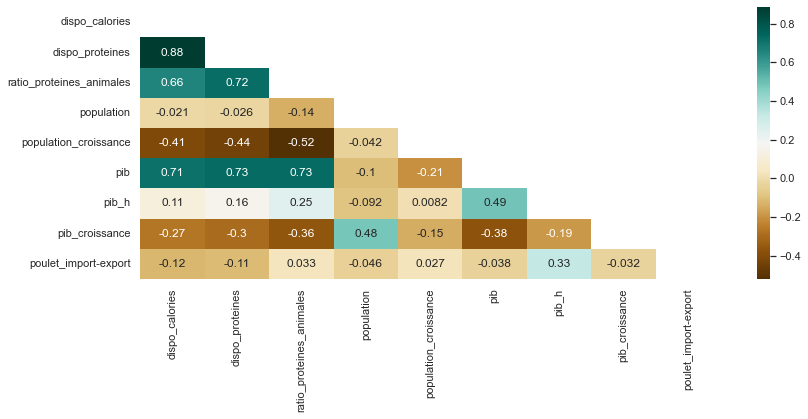

In [34]:
# Calculate pairwise-correlation
matrix = df.corr()

# Triangle de corrélations
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(13, 5))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.show()

### Normalisation

In [35]:
df.describe()

,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3007.800000,86.405200,0.454784,63.200804,1.132678,25095.344000,0.006509,1.197033,426.251852
std,428.917029,18.953652,0.143988,198.734660,0.152900,20884.179617,0.021316,0.218673,2233.638272
min,1981.000000,46.940000,0.141283,0.385637,0.871890,1196.500000,0.000005,0.691271,0.000000
25%,2697.500000,67.255000,0.347529,5.314561,1.029482,8645.525000,0.000259,1.051039,0.838921
50%,3051.000000,86.960000,0.487820,11.483611,1.112964,17899.150000,0.001299,1.185242,4.442613
75%,3343.250000,103.387500,0.568652,44.944077,1.198523,38222.200000,0.004680,1.302479,31.703649
max,3885.000000,126.650000,0.680987,1427.647786,1.755557,114110.000000,0.188847,2.056280,19536.000000


In [36]:
categorial = ['continent', 'pays', 'iso_a3', 'geometry']
variables_non_std = df.drop(categorial + ['ratio_proteines_animales', 'population_croissance', 'pib_croissance'], axis=1)
X = variables_non_std #dispo_calories + dispo_proteines + population + pib + pibh + poulet
variables_non_std

,dispo_calories,dispo_proteines,population,pib,pib_h,poulet_import-export
0,2781.0,71.14,0.883483,13808.1,0.015629,13.662252
1,2373.0,58.93,56.313438,2590.0,0.000046,43.307692
2,3566.0,104.12,37.074562,48924.4,0.001320,1.568819
3,3782.0,113.74,327.096265,61544.4,0.000188,0.019352
4,3067.0,91.49,18.319618,25544.3,0.001394,31.774596
...,...,...,...,...,...,...
95,3292.0,97.52,98.423598,11366.3,0.000115,136.959752
96,1981.0,46.94,42.729036,2122.1,0.000050,0.344573
97,3307.0,98.82,3.323925,14419.6,0.004338,2.181634
98,3072.0,84.49,2.082957,15944.0,0.007655,83.118568


In [37]:
from sklearn.preprocessing import normalize
X_scaled = normalize(X) #

# Jointure avec les variables normalisées
df_std = pd.merge(
    df.drop(variables_non_std.columns, axis=1), # Variables ne nécessistant pas une normalisation
    pd.DataFrame(X_scaled, columns=variables_non_std.columns), # Variables déjà normalisées
    left_index=True, right_index=True)

df_std

,continent,pays,iso_a3,geometry,ratio_proteines_animales,population_croissance,pib_croissance,dispo_calories,dispo_proteines,population,pib,pib_h,poulet_import-export
0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.399635,1.045096,1.310489,0.197436,0.005051,0.000063,0.980302,1.109588e-06,9.699478e-04
1,Africa,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.206007,1.345475,1.363517,0.675311,0.016770,0.016026,0.737065,1.308862e-08,1.232455e-02
2,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.545044,1.112093,1.061469,0.072695,0.002123,0.000756,0.997352,2.690124e-08,3.198127e-05
3,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.646035,1.077797,1.111030,0.061335,0.001845,0.005305,0.998101,3.051400e-09,3.138371e-07
4,Asia,Kazakhstan,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",0.597880,1.154929,1.283627,0.119209,0.003556,0.000712,0.992862,5.419664e-08,1.235022e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Africa,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",0.270919,1.235917,1.164162,0.278157,0.008240,0.008316,0.960394,9.757766e-09,1.157240e-02
96,Africa,Uganda,UGA,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736...",0.260971,1.404095,1.208141,0.682224,0.016165,0.014715,0.730816,1.710351e-08,1.186654e-04
97,Europe,Bosnia and Herzegovina,BIH,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",0.374216,0.885372,1.289710,0.223532,0.006680,0.000225,0.974674,2.932297e-07,1.474646e-04
98,Europe,North Macedonia,MKD,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",0.432832,1.007567,1.231777,0.189190,0.005203,0.000128,0.981913,4.714036e-07,5.118869e-03


In [38]:
df_std.describe()

,ratio_proteines_animales,population_croissance,pib_croissance,dispo_calories,dispo_proteines,population,pib,pib_h,poulet_import-export
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000
mean,0.454784,1.132678,1.197033,0.227394,0.006225,0.005891,0.941274,1.907658e-07,0.030906
std,0.143988,0.152900,0.218673,0.192240,0.005115,0.021517,0.105064,3.599276e-07,0.115765
min,0.141283,0.871890,0.691271,0.030351,0.000952,0.000005,0.421799,6.761622e-10,0.000000
25%,0.347529,1.029482,1.051039,0.082764,0.002498,0.000214,0.953808,1.930648e-08,0.000030
50%,0.487820,1.112964,1.185242,0.158154,0.004274,0.000761,0.987013,7.515395e-08,0.000197
75%,0.568652,1.198523,1.302479,0.280879,0.007577,0.003388,0.996512,1.837584e-07,0.002643
max,0.680987,1.755557,2.056280,0.905994,0.029119,0.190422,0.999539,2.266971e-06,0.778994


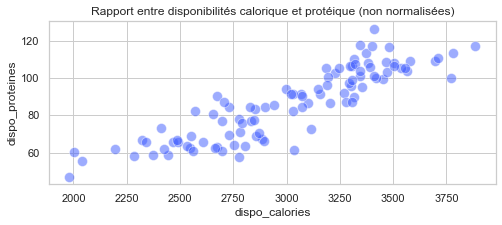

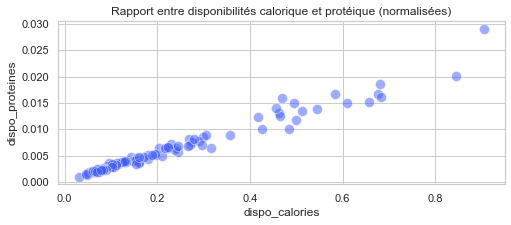

In [39]:
plt.figure(figsize=(8, 3))
sns.scatterplot(data=df, x='dispo_calories', y='dispo_proteines', s=100, alpha=.5, color=indigo_a400)
plt.title('Rapport entre disponibilités calorique et protéique (non normalisées)')
plt.show()

plt.figure(figsize=(8, 3))
sns.scatterplot(data=df_std, x='dispo_calories', y='dispo_proteines', s=100, alpha=.5, color=indigo_a400)
plt.title('Rapport entre disponibilités calorique et protéique (normalisées)')
plt.show()

## ACP

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


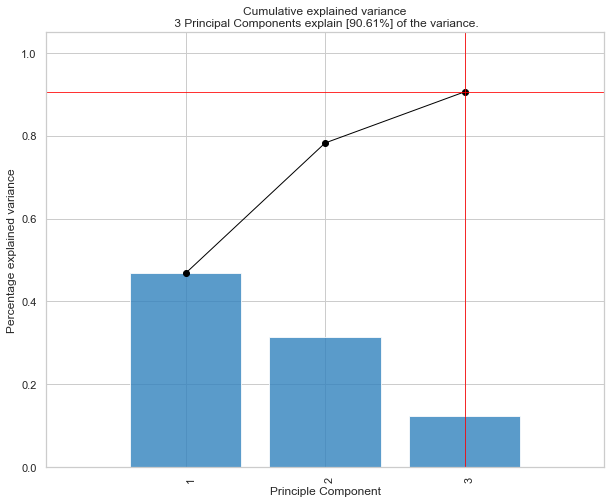

<Figure size 576x360 with 0 Axes>

In [40]:
#categorial = ['continent', 'pays', 'iso_a3', 'geometry']
from pca import pca
model = pca(n_components=3)
results = model.fit_transform(df_std.drop(categorial + ['dispo_calories'], axis=1))
fig, ax = model.plot()
plt.show()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


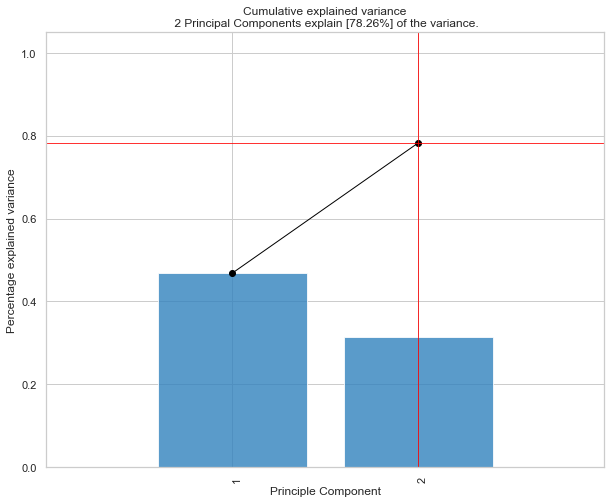

<Figure size 576x360 with 0 Axes>

In [41]:
#categorial = ['continent', 'pays', 'iso_a3', 'geometry']
from pca import pca
model = pca(n_components=2)
results = model.fit_transform(df_std.drop(categorial + ['dispo_calories'], axis=1))
features = df_std.columns
fig, ax = model.plot()
plt.show()

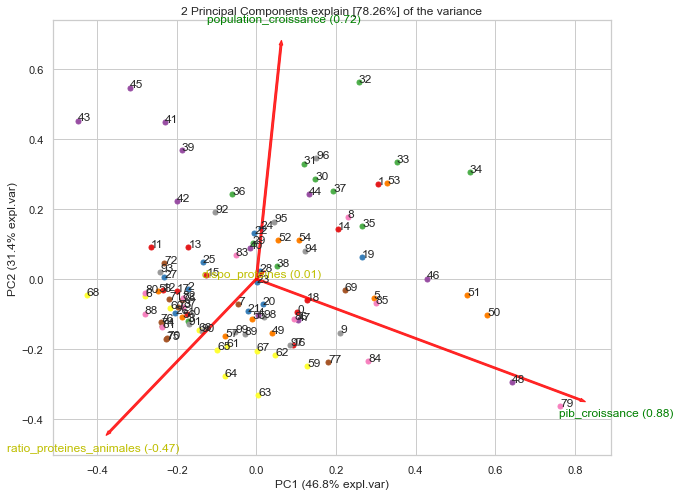

In [42]:
fig, ax = model.biplot(n_feat=4, legend=None)

### Clusters

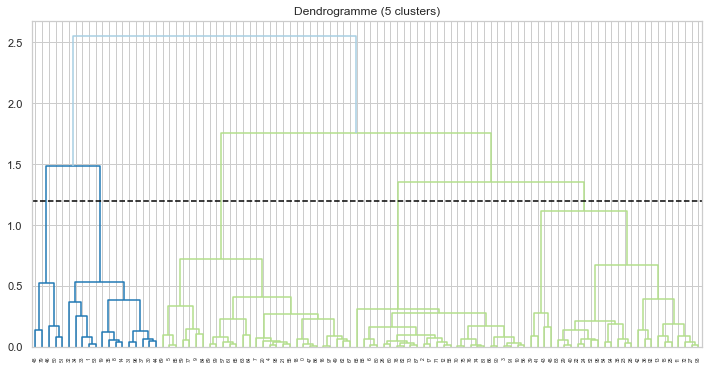

In [43]:
# Dendrogramme sur les 2 composantes de l'ACP
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(12, 6))  
shc.dendrogram(shc.linkage(results['PC'], method='ward'))
plt.axhline(y=1.2, color='black', linestyle='dashed') # Threshold
plt.title('Dendrogramme (5 clusters)')  
plt.savefig('dendrogramme.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# Récupération du cluster de chaque individu
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
clusters = pd.DataFrame(cluster.fit_predict(results['PC']), columns=['cluster'])
deux_composantes = pd.merge(results['PC'], clusters, left_index=True, right_index=True)
deux_composantes = pd.merge(deux_composantes, df['pays'], left_index=True, right_index=True)
print(deux_composantes)

         PC1       PC2  cluster                         pays
0   0.102385 -0.095844        2                         Fiji
1   0.304909  0.271863        1  United Republic of Tanzania
2  -0.173018 -0.029008        4                       Canada
3  -0.171952 -0.119937        4     United States of America
4   0.004607 -0.104050        2                   Kazakhstan
..       ...       ...      ...                          ...
95  0.044333  0.164354        0                        Egypt
96  0.150891  0.346455        1                       Uganda
97  0.084917 -0.189444        2       Bosnia and Herzegovina
98  0.017925 -0.109169        2              North Macedonia
99 -0.052556 -0.151202        2                       Serbia

[100 rows x 4 columns]


In [45]:
deux_composantes[['pays', 'cluster']].to_csv('clusters_pays.csv')

## Centroïdes

In [46]:
# Calcul des centroïdes de chaque composante
centroides = deux_composantes.groupby(['cluster']).mean().reset_index()
centroides['cluster'] = 'centroïde'
centroides['pays'] = 'centroïde'
centroides

,cluster,PC1,PC2,pays
0,centroïde,-0.101145,0.147905,centroïde
1,centroïde,0.249013,0.267396,centroïde
2,centroïde,0.064166,-0.152335,centroïde
3,centroïde,0.588717,-0.161360,centroïde
4,centroïde,-0.217723,-0.090945,centroïde


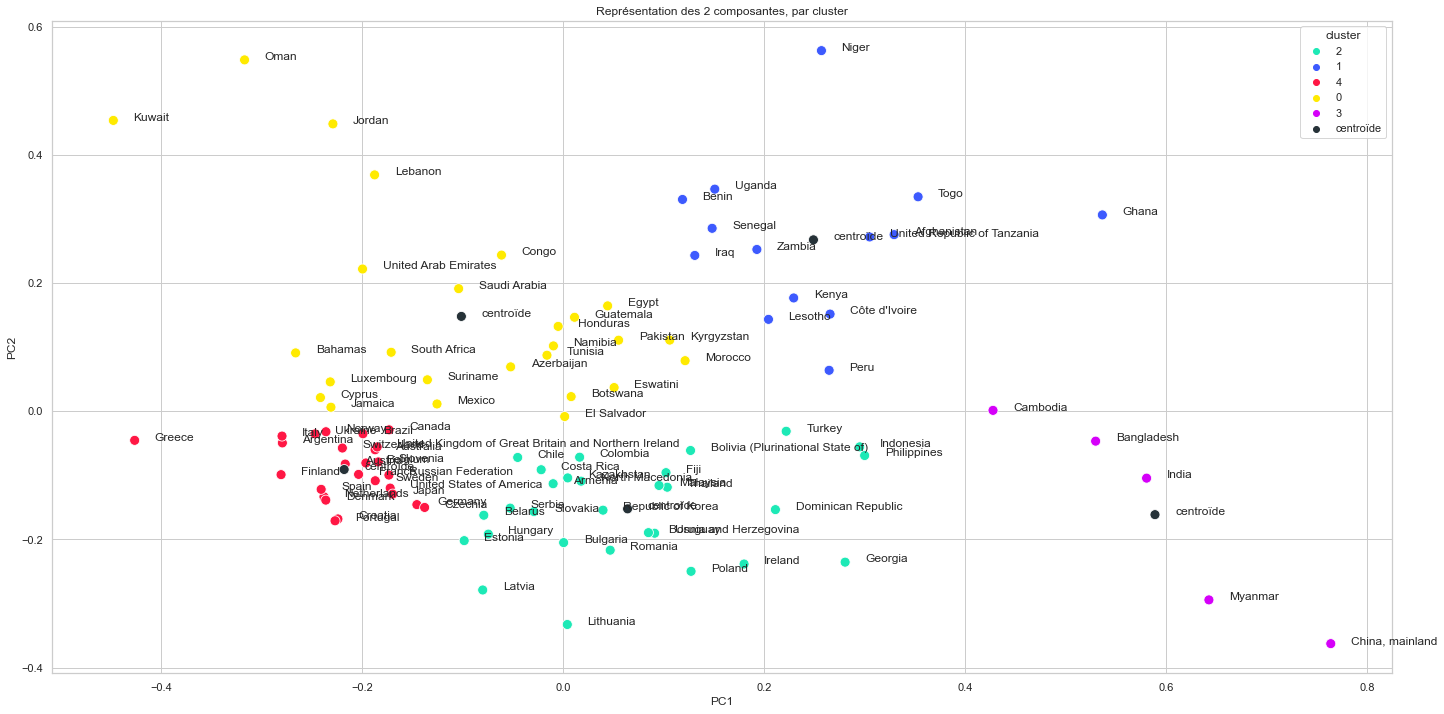

In [47]:
# Jointure des centroïdes sur la dataframe
deux_composantes_centroides = pd.concat([deux_composantes, centroides])

# Scatterplot des 2 composantes
plt.figure(figsize=(24,12))
ax = sns.scatterplot(data=deux_composantes_centroides, x='PC1', y='PC2', hue='cluster', s=100, 
                     palette=[teal_a400, indigo_a400, red_a400, yellow_a400, purple_a400, bluegrey_900])

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(deux_composantes_centroides['PC1'], deux_composantes_centroides['PC2'], deux_composantes_centroides['pays'], plt.gca())
plt.title('Représentation des 2 composantes, par cluster')
plt.show()

In [48]:
# Jointure des données non normalisées avec les clusters et coordonnées de l'ACP
df = pd.merge(df, deux_composantes, how='left', on='pays')
df

,continent,pays,iso_a3,geometry,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export,PC1,PC2,cluster
0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2781.0,71.14,0.399635,0.883483,1.045096,13808.1,0.015629,1.310489,13.662252,0.102385,-0.095844,2
1,Africa,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",2373.0,58.93,0.206007,56.313438,1.345475,2590.0,0.000046,1.363517,43.307692,0.304909,0.271863,1
2,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",3566.0,104.12,0.545044,37.074562,1.112093,48924.4,0.001320,1.061469,1.568819,-0.173018,-0.029008,4
3,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3782.0,113.74,0.646035,327.096265,1.077797,61544.4,0.000188,1.111030,0.019352,-0.171952,-0.119937,4
4,Asia,Kazakhstan,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",3067.0,91.49,0.597880,18.319618,1.154929,25544.3,0.001394,1.283627,31.774596,0.004607,-0.104050,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Africa,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",3292.0,97.52,0.270919,98.423598,1.235917,11366.3,0.000115,1.164162,136.959752,0.044333,0.164354,0
96,Africa,Uganda,UGA,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736...",1981.0,46.94,0.260971,42.729036,1.404095,2122.1,0.000050,1.208141,0.344573,0.150891,0.346455,1
97,Europe,Bosnia and Herzegovina,BIH,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",3307.0,98.82,0.374216,3.323925,0.885372,14419.6,0.004338,1.289710,2.181634,0.084917,-0.189444,2
98,Europe,North Macedonia,MKD,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",3072.0,84.49,0.432832,2.082957,1.007567,15944.0,0.007655,1.231777,83.118568,0.017925,-0.109169,2


In [49]:
# Moyenne des variables non standardisées, par cluster
groupes_centroides = df.groupby(['cluster']).mean().reset_index()

# Enregistrement de la liste des pays et clusters en CSV
groupes_centroides.to_csv('groupes_centroides.csv')
groupes_centroides

,cluster,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export,PC1,PC2
0,0,2894.846154,81.646538,0.406025,26.062976,1.237120,22403.076923,0.015457,1.054287,864.207262,-0.101145,0.147905
1,1,2458.928571,62.880000,0.230409,27.856962,1.301356,4304.750000,0.000252,1.299005,1279.513505,0.249013,0.267396
2,2,3106.620690,88.226897,0.503763,29.239332,1.039191,24292.937931,0.004970,1.315441,49.599890,0.064166,-0.152335
3,3,2691.000000,76.278000,0.316439,602.324977,1.109140,7073.980000,0.000079,1.794603,133.146437,0.588717,-0.161360
4,4,3367.000000,103.746923,0.596336,53.572308,1.046210,43343.184615,0.003884,1.037882,5.326090,-0.217723,-0.090945


In [50]:
# Pays dans chaque cluster
for i in df.sort_values('cluster')['cluster'].unique():
    print('Cluster', i, ':', len(df[df['cluster']==i]), 'pays\n' + 
        ', '.join(df[df['cluster']==i]['pays'].values), '\n' + '- '*3)

Cluster 0 : 26 pays
Bahamas, South Africa, Mexico, Honduras, El Salvador, Guatemala, Suriname, Jamaica, Botswana, Namibia, Congo, Eswatini, Lebanon, Tunisia, Jordan, United Arab Emirates, Kuwait, Oman, Pakistan, Kyrgyzstan, Luxembourg, Azerbaijan, Saudi Arabia, Cyprus, Morocco, Egypt 
- - - 
Cluster 1 : 14 pays
United Republic of Tanzania, Kenya, Lesotho, Peru, Senegal, Benin, Niger, Togo, Ghana, Côte d'Ivoire, Zambia, Iraq, Afghanistan, Uganda 
- - - 
Cluster 2 : 29 pays
Fiji, Kazakhstan, Indonesia, Chile, Dominican Republic, Uruguay, Bolivia (Plurinational State of), Colombia, Costa Rica, Thailand, Republic of Korea, Armenia, Belarus, Poland, Hungary, Romania, Lithuania, Latvia, Estonia, Bulgaria, Turkey, Ireland, Georgia, Philippines, Malaysia, Slovakia, Bosnia and Herzegovina, North Macedonia, Serbia 
- - - 
Cluster 3 : 5 pays
Cambodia, Myanmar, India, Bangladesh, China, mainland 
- - - 
Cluster 4 : 26 pays
Canada, United States of America, Argentina, Russian Federation, Norway, Br

# Tests statistiques
## Tests d'adéquation
On souhaite vérifier que les variables suivent une loi normale.
H$_0$ est l'hypothèse d'égalité à ne pas rejeter. Si H$_0$ est vraie, alors l'échantillon suit une loi normale.
On retient 5% de risque (pvalue=0,05).
Si pvalue < 0,05 = distribution probablement normale.

### Test de shapiro wilk

In [51]:
poulet_sha = df['poulet_import-export']
shapiro(poulet_sha) # suit une loi normale

ShapiroResult(statistic=0.188673734664917, pvalue=5.4391951841924074e-21)

In [52]:
dispo_proteines_sha = df['dispo_proteines']
shapiro(dispo_proteines_sha) # suit une loi normale

ShapiroResult(statistic=0.955100417137146, pvalue=0.0018268085550516844)

In [53]:
pib_h_sha = df['pib_h']
shapiro(pib_h_sha) # suit une loi normale

ShapiroResult(statistic=0.28257280588150024, pvalue=6.8744686575552e-20)

In [54]:
pib_croissance_sha = df['pib_croissance']
shapiro(pib_croissance_sha) # suit une loi normale

ShapiroResult(statistic=0.9415257573127747, pvalue=0.00023915631754789501)

In [55]:
ratio_proteines_animales_sha = df['ratio_proteines_animales']
shapiro(ratio_proteines_animales_sha) # suit une loi normale

ShapiroResult(statistic=0.9472622871398926, pvalue=0.0005501111736521125)

In [56]:
population_sha = df['population']
shapiro(population_sha) # suit une loi normale

ShapiroResult(statistic=0.2858465313911438, pvalue=7.543785727611604e-20)

## Tests de comparaison
Comparaison des variances et moyennes de deux populations pour vérifier qu'elles sont bien différentes.
Variance :
Si paramétrique => test de Barlett
Si non paramétrique => Fligner Killeen
Moyenne :
Si paramétrique => test de Student
Si non paramétrique => test de Mann Whitney

In [57]:
# Tests paramétrique (Barlett)
cluster_1 = df[df["cluster"]==0]["poulet_import-export"]
cluster_3 = df[df["cluster"]==2]["poulet_import-export"]
sp.stats.bartlett(cluster_1,cluster_3) # égalité des variances non vérifiée

BartlettResult(statistic=134.71297646268246, pvalue=3.815206787311598e-31)

In [58]:
# Test de Student
sp.stats.ttest_ind(cluster_1,cluster_3) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=1.1481913155731156, pvalue=0.25604567894248725)

In [59]:
# Test de Barlett
cluster_1 = df[df["cluster"]==0]["dispo_proteines"]
cluster_3 = df[df["cluster"]==2]["dispo_proteines"]
sp.stats.bartlett(cluster_1,cluster_3) # égalité des variances non vérifiée

BartlettResult(statistic=0.09176642048035318, pvalue=0.7619434150054035)

In [60]:
# Test de Student
sp.stats.ttest_ind(cluster_1,cluster_3) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=-1.4797789357923647, pvalue=0.14485220791300324)

In [61]:
# Test de Barlett
cluster_1 = df[df["cluster"]==0]["pib_h"]
cluster_3 = df[df["cluster"]==2]["pib_h"]
sp.stats.bartlett(cluster_1,cluster_3) # égalité des variances vérifiée

BartlettResult(statistic=62.54500540918555, pvalue=2.604249076143072e-15)

In [62]:
# Test de Student
sp.stats.ttest_ind(cluster_1,cluster_3) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=1.389340596744652, pvalue=0.17053887541017093)

In [63]:
# Test de Barlett
cluster_1 = df[df["cluster"]==0]["population"]
cluster_3 = df[df["cluster"]==2]["population"]
sp.stats.bartlett(cluster_1,cluster_3) # égalité des variances non vérifiée

BartlettResult(statistic=0.17895544442375835, pvalue=0.6722724560122973)

In [64]:
# Test de Student
sp.stats.ttest_ind(cluster_1,cluster_3) # égalité des moyennes non vérifiée

Ttest_indResult(statistic=-0.2297249852247354, pvalue=0.8191897767648813)

In [65]:
# Tests paramétrique (Barlett)
cluster_1 = df[df["cluster"]==0]["pib_croissance"]
cluster_3 = df[df["cluster"]==2]["pib_croissance"]
sp.stats.bartlett(cluster_1,cluster_3) # égalité des variances non vérifiée

BartlettResult(statistic=1.6411897838534482, pvalue=0.2001623031981685)

In [66]:
# Test Wilcoxon
sp.stats.ttest_ind(cluster_1,cluster_3) # égalité des moyennes vérifiée

Ttest_indResult(statistic=-7.815131390456655, pvalue=2.210236664648617e-10)

Les égalités des variances et des moyennes n'étant pas vérifiées, on peut conclure que les deux clusters sont différents.

# Analyse des clusters

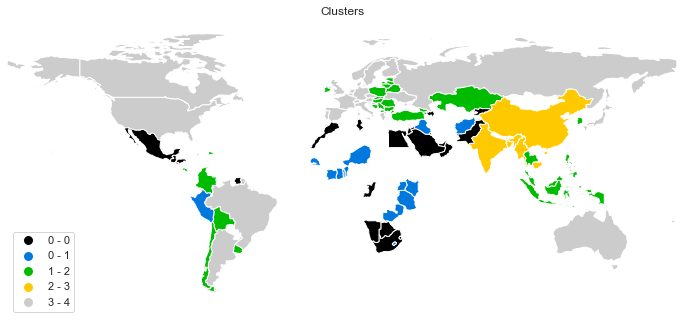

In [67]:
geoplot.choropleth(
    df, hue='cluster', edgecolor='white', linewidth=1,
    cmap='nipy_spectral', legend=True, scheme='FisherJenks', figsize=(12, 15))
plt.title('Clusters')
plt.show()

## Bilan alimentaire

On a pu observer précédemment que le cluster 2 a une disponibilité en protéines bien plus faible que les autres.

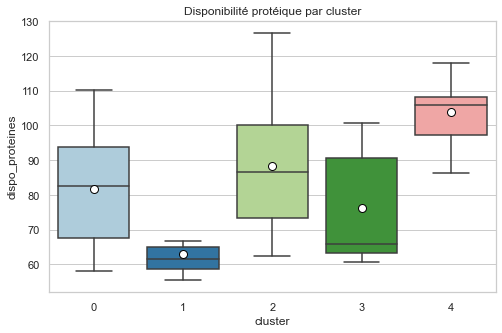

In [68]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=df, y='dispo_proteines', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Disponibilité protéique par cluster')
plt.show()

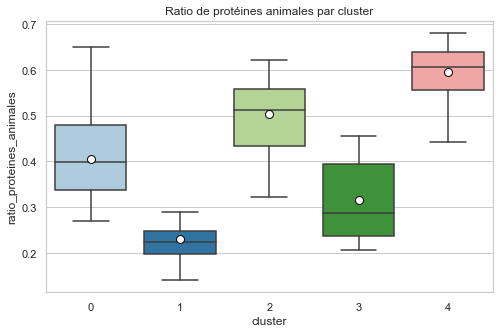

In [69]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=df, y='ratio_proteines_animales', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Ratio de protéines animales par cluster')
plt.show()

Les pays du cluster 2 consomment moins de protéines et de protéines. animales. Il convient donc de l'écarter.

In [70]:
print('Cluster à écarter :', df[df['cluster']==1]['pays'].unique())
quatre_groupes = df.drop(df[df['cluster']==1].index)

Cluster à écarter : ['United Republic of Tanzania' 'Kenya' 'Lesotho' 'Peru' 'Senegal' 'Benin'
 'Niger' 'Togo' 'Ghana' "Côte d'Ivoire" 'Zambia' 'Iraq' 'Afghanistan'
 'Uganda']


## PIB

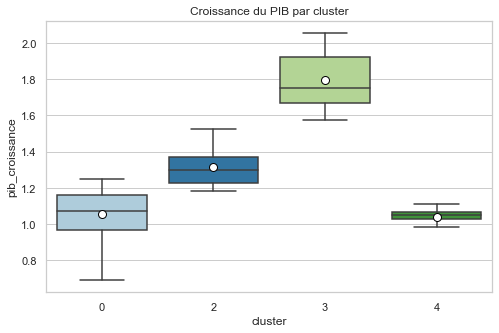

In [71]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=quatre_groupes, y='pib_croissance', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Croissance du PIB par cluster')
plt.show()

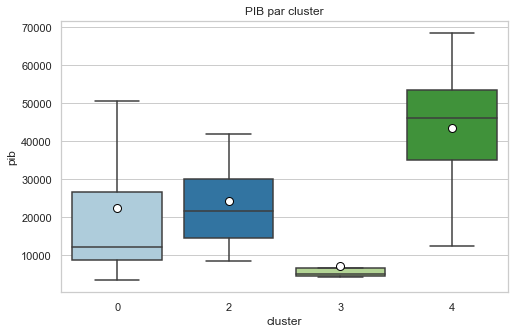

In [72]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=quatre_groupes, y='pib', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('PIB par cluster')
plt.show()

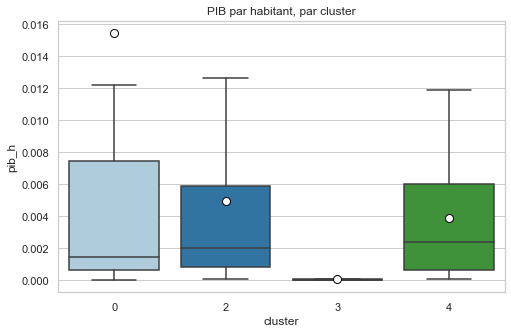

In [73]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=quatre_groupes, y='pib_h', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('PIB par habitant, par cluster')
plt.show()

Le cluster 4 a une forte croissance de PIB mais le PIB et le PIB par habitant restent faibles. Il convient donc de l'écarter.

In [74]:
print('Cluster à mettre de côté :', quatre_groupes[quatre_groupes['cluster']==3]['pays'].unique())
trois_groupes = quatre_groupes.drop(quatre_groupes[quatre_groupes['cluster']==3].index)

Cluster à mettre de côté : ['Cambodia' 'Myanmar' 'India' 'Bangladesh' 'China, mainland']


## Import / export de poulet

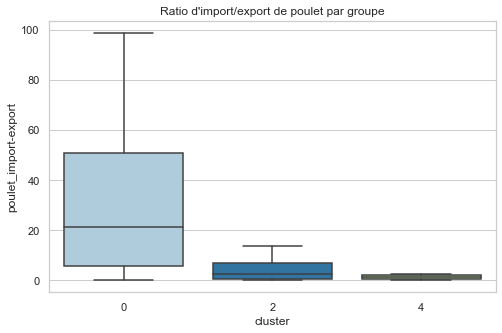

In [75]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=trois_groupes, y='poulet_import-export', x='cluster', showfliers=False)
plt.title('Ratio d\'import/export de poulet par groupe')
plt.show()

Le cluster 5 importe beaucoup moins qu'il n'exporte. Il convient donc de l'écarter.

In [76]:
print('Cluster à mettre de côté :', trois_groupes[trois_groupes['cluster']==4]['pays'].unique())
deux_groupes = trois_groupes.drop(trois_groupes[trois_groupes['cluster']==4].index)

Cluster à mettre de côté : ['Canada' 'United States of America' 'Argentina' 'Russian Federation'
 'Norway' 'Brazil' 'France' 'Sweden' 'Ukraine' 'Austria' 'Germany'
 'Greece' 'Croatia' 'Switzerland' 'Belgium' 'Netherlands' 'Portugal'
 'Spain' 'Australia' 'Italy' 'Denmark'
 'United Kingdom of Great Britain and Northern Ireland' 'Slovenia'
 'Finland' 'Czechia' 'Japan']


## Population

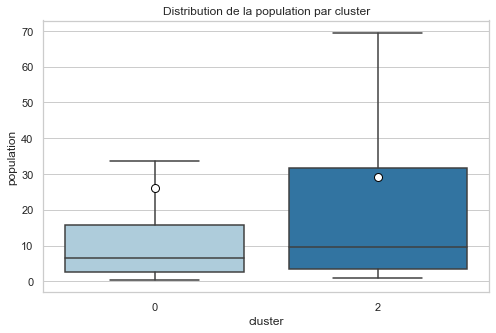

In [77]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=deux_groupes, y='population', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Distribution de la population par cluster')
plt.show()

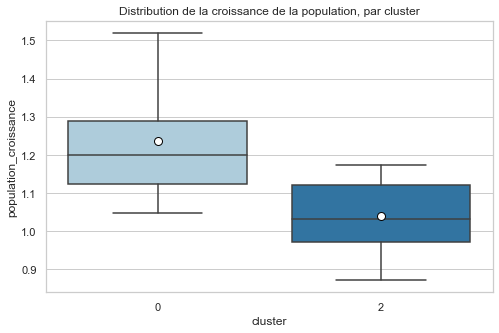

In [78]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=deux_groupes, y='population_croissance', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Distribution de la croissance de la population, par cluster')
plt.show()

Le cluster 1 a une plus faible population mais sa croissance est forte. Il convient de le sélectionner car son importation de poulet est beaucoup plus forte que celle du 3.

In [79]:
print('Cluster à mettre de côté :', deux_groupes[deux_groupes['cluster']==2]['pays'].unique())
groupe = deux_groupes.drop(deux_groupes[deux_groupes['cluster']==2].index)

Cluster à mettre de côté : ['Fiji' 'Kazakhstan' 'Indonesia' 'Chile' 'Dominican Republic' 'Uruguay'
 'Bolivia (Plurinational State of)' 'Colombia' 'Costa Rica' 'Thailand'
 'Republic of Korea' 'Armenia' 'Belarus' 'Poland' 'Hungary' 'Romania'
 'Lithuania' 'Latvia' 'Estonia' 'Bulgaria' 'Turkey' 'Ireland' 'Georgia'
 'Philippines' 'Malaysia' 'Slovakia' 'Bosnia and Herzegovina'
 'North Macedonia' 'Serbia']


# Cluster sélectionné


In [80]:
groupe.sort_values(by='poulet_import-export', ascending=False)

,continent,pays,iso_a3,geometry,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,pib_h,pib_croissance,poulet_import-export,PC1,PC2,cluster
11,North America,Bahamas,BHS,"MULTIPOLYGON (((-78.98000 26.79000, -78.51000 ...",2655.0,80.69,0.649399,0.385637,1.122078,35500.5,0.092057,0.902964,19536.000000,-0.266003,0.090974,0
54,Asia,Kyrgyzstan,KGZ,"POLYGON ((70.96231 42.26615, 71.18628 42.70429...",2729.0,84.41,0.401730,6.304030,1.199630,5133.2,0.000814,1.239245,1396.210526,0.106077,0.110937,0
36,Africa,Congo,COG,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...",2285.0,58.16,0.453748,5.244359,1.307336,3414.4,0.000651,1.055162,865.287879,-0.061224,0.243556,0
95,Africa,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",3292.0,97.52,0.270919,98.423598,1.235917,11366.3,0.000115,1.164162,136.959752,0.044333,0.164354,0
28,Africa,Botswana,BWA,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2342.0,65.89,0.425254,2.254068,1.176666,17634.1,0.007823,1.206501,123.843750,0.008035,0.022772,0
15,North America,Mexico,MEX,"POLYGON ((-117.12776 32.53534, -115.99135 32.6...",3157.0,91.50,0.489399,126.190788,1.138749,19992.2,0.000158,1.085100,98.666176,-0.125376,0.011301,0
83,Asia,Azerbaijan,AZE,"MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...",3149.0,94.42,0.344524,9.949537,1.127826,14209.6,0.001428,1.101255,54.939689,-0.052143,0.069188,0
22,North America,Honduras,HND,"POLYGON ((-83.14722 14.99583, -83.48999 15.016...",2673.0,62.95,0.348531,9.587522,1.201300,5672.3,0.000592,1.131834,37.466830,-0.004875,0.132335,0
24,North America,Guatemala,GTM,"POLYGON ((-92.22775 14.53883, -92.20323 14.830...",2551.0,68.99,0.315263,17.247849,1.231424,8448.5,0.000490,1.147473,36.792619,0.011400,0.146555,0
25,South America,Suriname,SUR,"POLYGON ((-54.52475 2.31185, -55.09759 2.52375...",2698.0,60.73,0.406883,0.575990,1.113836,16609.4,0.028836,1.039283,26.148633,-0.134933,0.049039,0


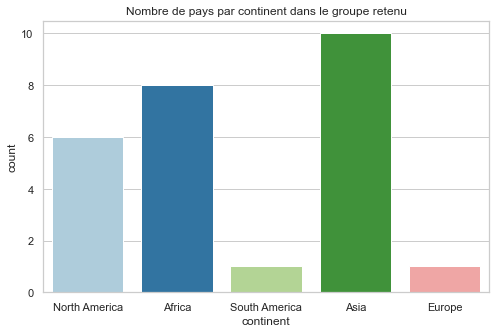

In [81]:
sns.countplot(data=groupe, x='continent')
plt.title('Nombre de pays par continent dans le groupe retenu')
plt.show()

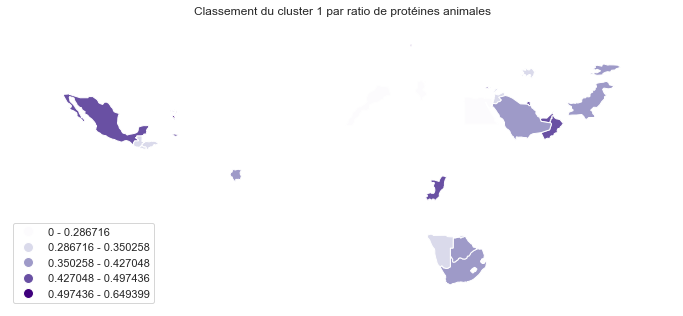

In [82]:
geoplot.choropleth(
    groupe, hue='ratio_proteines_animales', edgecolor='white', linewidth=1,
    cmap='Purples', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Classement du cluster 1 par ratio de protéines animales')
plt.show()

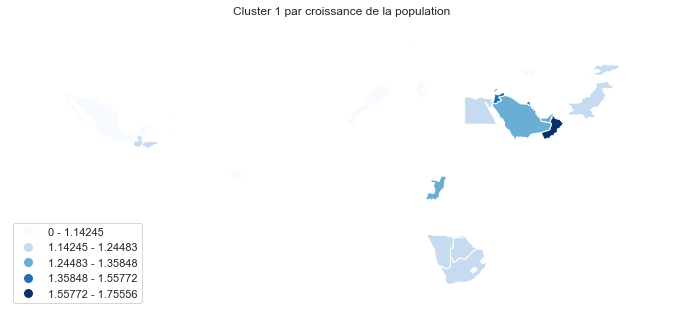

In [83]:
geoplot.choropleth(
    groupe, hue='population_croissance', edgecolor='white', linewidth=1,
    cmap='Blues', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Cluster 1 par croissance de la population')
plt.show()

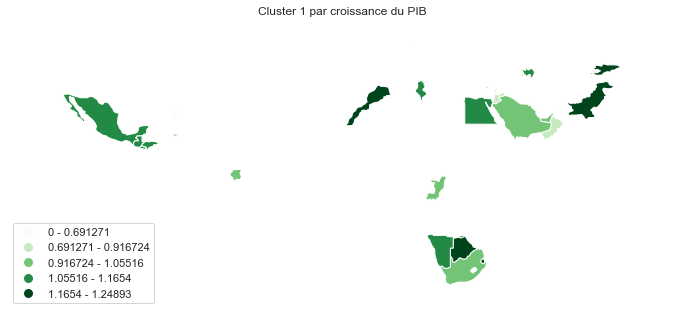

In [84]:
geoplot.choropleth(
    groupe, hue='pib_croissance', edgecolor='white', linewidth=1,
    cmap='Greens', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Cluster 1 par croissance du PIB')
plt.show()

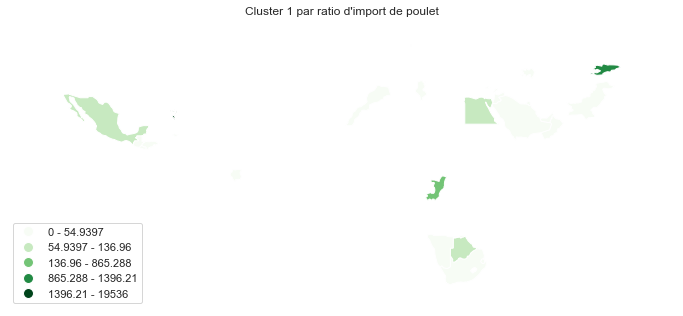

In [85]:
geoplot.choropleth(
    groupe, hue='poulet_import-export', edgecolor='white', linewidth=1,
    cmap='Greens', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Cluster 1 par ratio d\'import de poulet')
plt.show()